# Homework 6: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

We have provided training and testing datasets for you to use, that way you're not going to introduce the problem of random sampling when you test your models.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

3. Tune your Random Forest model by varying hyperparamters (15 points).

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

4. Report the most important feature(s) based on your Random Forest classifier (10 points).

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


## Import Libraries and Data

In [233]:
import numpy as np
import pandas as pd
import scipy as sp

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [173]:
data = pd.read_csv('malicious_and_benign.csv')

In [301]:
data.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSETcode,SERVERcode,WHOIS_COUNTRYcode
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,9,10,1153,832,9,2.0,1,4,201,29
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,17,19,1265,1230,17,0.0,0,3,62,29
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0.0,0,5,116,29
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,39,37,18784,4380,39,8.0,0,1,201,42
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,61,62,129889,4586,61,4.0,0,3,125,42


In [175]:
test_csv = pd.read_csv('malicious_and_benign_test.csv')
test_csv.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2211,78,15,ISO-8859-1,Varnish,9.0,US,DC,18/10/2005 0:00,14/10/2016 0:00,...,6,6,672,8,9,562,672,8,0.0,0
1,B0_854,39,8,utf-8,YouTubeFrontEnd,NaN,US,CA,15/02/2005 0:00,14/01/2017 0:00,...,0,0,0,0,0,0,0,0,0.0,0
2,B0_242,43,9,utf-8,Varnish,389.0,US,CA,16/07/1999 0:00,29/03/2013 0:00,...,2,3,6008,87,107,147266,6312,87,4.0,0
3,B0_880,52,10,ISO-8859-1,Apache,5443.0,CA,Quebec,14/10/2007 12:24,1/09/2016 14:20,...,0,0,0,0,0,0,0,0,0.0,0
4,M4_6,100,20,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,1,66,1,3,190,66,1,0.0,1


#### Clean column data 

In [176]:
#--NOTE: half of the values are nan for CONTENT_LENGTH-- 
data.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [177]:
#--Put 0 in place of NAN values--
data.SERVER.fillna(0, inplace=True)
data.CONTENT_LENGTH.fillna(0, inplace=True)
data.DNS_QUERY_TIMES.fillna(0, inplace=True)
data.isna().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

In [178]:
#--Use Label Encoder: creates new column with numerical value for label--    
data.CHARSET.str.lower()
data.CHARSET = pd.Categorical(data.CHARSET)
data['CHARSETcode'] = data.CHARSET.cat.codes

data.SERVER.str.lower()
data.SERVER = pd.Categorical(data.SERVER)
data['SERVERcode'] = data.SERVER.cat.codes

data.WHOIS_COUNTRY.str.lower()
data.WHOIS_COUNTRY = pd.Categorical(data.WHOIS_COUNTRY)
data['WHOIS_COUNTRYcode'] = data.WHOIS_COUNTRY.cat.codes

In [78]:
data.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,code,CHARSETcode,SERVERcode,WHOIS_COUNTRYcode
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,10,1153,832,9,2.0,1,4,4,201,29
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,19,1265,1230,17,0.0,0,3,3,62,29
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0.0,0,5,5,116,29
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,37,18784,4380,39,8.0,0,1,1,201,42
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,62,129889,4586,61,4.0,0,3,3,125,42


In [179]:
#--Put 0 in place of NAN values--
test_csv.CONTENT_LENGTH.fillna(0, inplace=True)
test_csv.isna().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

In [184]:
#--Use Label Encoder: creates new column with numerical value for label--    
test_csv.CHARSET.str.lower()
test_csv.CHARSET = pd.Categorical(test_csv.CHARSET)
test_csv['CHARSETcode'] = test_csv.CHARSET.cat.codes

test_csv.SERVER.str.lower()
test_csv.SERVER = pd.Categorical(test_csv.SERVER)
test_csv['SERVERcode'] = test_csv.SERVER.cat.codes

test_csv.WHOIS_COUNTRY.str.lower()
test_csv.WHOIS_COUNTRY = pd.Categorical(test_csv.WHOIS_COUNTRY)
test_csv['WHOIS_COUNTRYcode'] = test_csv.WHOIS_COUNTRY.cat.codes

In [84]:
test_csv

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSETcode,SERVERcode,WHOIS_COUNTRYcode
0,B0_2211,78,15,ISO-8859-1,Varnish,9.0,US,DC,18/10/2005 0:00,14/10/2016 0:00,...,8,9,562,672,8,0.0,0,0,49,25
1,B0_854,39,8,utf-8,YouTubeFrontEnd,0.0,US,CA,15/02/2005 0:00,14/01/2017 0:00,...,0,0,0,0,0,0.0,0,5,51,25
2,B0_242,43,9,utf-8,Varnish,389.0,US,CA,16/07/1999 0:00,29/03/2013 0:00,...,87,107,147266,6312,87,4.0,0,5,49,25
3,B0_880,52,10,ISO-8859-1,Apache,5443.0,CA,Quebec,14/10/2007 12:24,1/09/2016 14:20,...,0,0,0,0,0,0.0,0,0,5,4
4,M4_6,100,20,UTF-8,Apache,0.0,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,1,3,190,66,1,0.0,1,2,5,9
5,B0_2012,61,12,ISO-8859-1,nginx,1522.0,US,Ohio,8/01/2004 0:00,3/01/2017 0:00,...,4,6,376,432,4,0.0,0,0,65,25
6,M0_56,61,12,ISO-8859-1,Apache,526.0,DE,None,10/09/2003 0:00,11/09/2016 0:00,...,0,2,124,0,0,0.0,1,0,5,8
7,B0_824,30,8,UTF-8,cloudflare-nginx,0.0,US,CA,25/02/2004 0:00,16/01/2016 0:00,...,0,0,0,0,0,0.0,0,2,53,25
8,B0_453,27,6,UTF-8,Apache/2.4.25,7967.0,None,None,28/04/1997 0:00,24/04/2017 0:00,...,8,11,812,787,8,2.0,0,2,26,17
9,B0_699,73,12,UTF-8,Server,0.0,US,NV,1/11/1994 0:00,30/04/2014 0:00,...,55,60,78671,5793,55,6.0,0,2,47,25


#### Merge data and drop duplicates to remove test data

In [185]:
#--Merge all data .CSV with test data .CSV to remove all duplicates -- this will give your training data only
merged_data = pd.concat([data, test_csv], sort=False)
train_data_only = merged_data.drop_duplicates(keep=False)

In [182]:
len(train_data_only)

2138

In [183]:
len(data) + len(test_csv)

2138

In [203]:
#--Remove: URL (too specific and would increase dimensionality too much), WHOIS_STATEPRO, WHOIS_REGDATE, WHOIS_UPDATED_DATE
delete_cols = ['URL', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'CONTENT_LENGTH']
keep_cols = ['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type']

keep = []
for col in keep_cols:
    if col not in delete_cols:
        keep.append(col)

clean_data = train_data_only[keep]
clean_test_csv = test_csv[keep]
# train_data.drop(cols_to_delete, axis=1, inplace=1)
clean_data.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,16,7,7,0,2,700,9,10,1153,832,9,2.0,1
1,16,6,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,16,6,0,0,0,0,0,0,0,0,0,0.0,0
3,17,6,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,17,6,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [204]:
clean_test_csv.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,78,15,8,6,6,672,8,9,562,672,8,0.0,0
1,39,8,0,0,0,0,0,0,0,0,0,0.0,0
2,43,9,83,2,3,6008,87,107,147266,6312,87,4.0,0
3,52,10,0,0,0,0,0,0,0,0,0,0.0,0
4,100,20,1,0,1,66,1,3,190,66,1,0.0,1


### Split Data into training and testing

In [205]:
train_data, test_data = train_test_split(clean_data, random_state=0)

## Random Forest Classifier (#1a - 3)

In [9]:
# fh = FeatureHasher()
# f = fh.transform(train_data)

In [206]:
len(train_data.columns)

13

In [207]:
train_data.dtypes

URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [208]:
train_data.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [234]:
#--1a. Build Random Forest Classifier to predict TYPE variable (10 pts)--
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(train_data.ix[:,:-1],train_data.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### Change number of folds in cross-validator for Random Forest

#### cv=10

In [235]:
#--2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points)--

#--NOTE: cv or kfolds validation is good to use on large datasets - In K-Folds Cross Validation we split our 
#--data into k different subsets (or folds). We use k-1 subsets to train our data and leave the last subset 
#--(or the last fold) as test data. We then average the model against each of the folds and then finalize our model.
#--After that we test it against the test set.

from sklearn.model_selection import GridSearchCV

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 4, 5, 7, 9, 10, 11, 12],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 12, 'n_estimators': 25}, Best score: 0.9650655021834061


In [211]:
grid_clf.best_score_

0.9644416718652526

#### cv=8

In [236]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 4, 5, 7, 9, 10, 11, 12],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=8)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 12, 'n_estimators': 25}, Best score: 0.9650655021834061


In [237]:
grid_clf.best_score_

0.9650655021834061

#### cv=6

In [240]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 4, 5, 7, 9, 10, 11, 12],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=6)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 11, 'n_estimators': 20}, Best score: 0.9681846537741734


In [241]:
grid_clf.best_score_

0.9681846537741734

#### cv=4

In [242]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 4, 5, 7, 9, 10, 11, 12],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=4)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 11, 'n_estimators': 20}, Best score: 0.9644416718652526


In [243]:
grid_clf.best_score_

0.9644416718652526

### Tune Random Forest by Varying Hyperparameters

#### Adding to n_estimators: 26,27,28; adding to max_depth: 13, 14, 15, 16

In [246]:
#--3. Tune your Random Forest model by varying hyperparamters (15 points)--
param_grid = {
                 'n_estimators': [23 ,24, 25, 26, 27, 28],
                 'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=6)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 16, 'n_estimators': 27}, Best score: 0.9694323144104804


In [247]:
grid_clf.best_score_

0.9694323144104804

#### Adding to n_estimators: 26,27,28, 29, 30; adding to max_depth: 13, 14, 15, 16, 17, 18 , 19

In [248]:
#--Where max_depth makes sure you don't get too many branches, or that it doesn't go too deep
#--Where n_estimators is the number of trees in the forest

param_grid = {
                 'n_estimators': [23 ,24, 25, 26, 27, 28, 29, 30],
                 'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=6)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 13, 'n_estimators': 26}, Best score: 0.9719276356830941


In [249]:
grid_clf.best_score_

0.9719276356830941

#### Removing to n_estimators: 24, 25, 26, 27, 28, 29, 30; adding to max_depth: 12, 13, 14, 15, 16, 17, 18, 19

In [252]:
param_grid = {
                 'n_estimators': [24, 25, 26, 27, 28, 29, 30],
                 'max_depth': [12, 13, 14, 15, 16, 17, 18, 19],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=6)
grid_clf.fit(train_data.ix[:,:-1],train_data.Type)

grid_clf.best_estimator_
print('Best params: {}, Best score: {}'.format(grid_clf.best_params_, grid_clf.best_score_))

Best params: {'max_depth': 12, 'n_estimators': 27}, Best score: 0.9694323144104804


In [253]:
grid_clf.best_score_

0.9694323144104804

## Naive Bayes Classifier (#1b and 4)

In [214]:
list(train_data.columns)

['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT',
 'REMOTE_IPS',
 'APP_BYTES',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'SOURCE_APP_BYTES',
 'REMOTE_APP_BYTES',
 'APP_PACKETS',
 'DNS_QUERY_TIMES',
 'Type']

In [215]:
train_data.loc[:, train_data.columns != 'Type'].head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
5,18,7,11,6,9,894,11,13,838,894,11,0.0
58,25,7,0,0,0,0,0,0,0,0,0,0.0
350,40,9,56,4,8,4551,60,59,67881,4843,60,4.0
73,32,9,14,1,4,1457,20,16,3229,1881,20,6.0
1271,64,13,0,0,0,0,0,0,0,0,0,0.0


#### Train Naive Bayes

In [254]:
#-- 1b. Build Naive Bayes Classifier to predict TYPE variable (10 pts)--
# train the model
gnb_model = sknb.GaussianNB()

#train the nb model to predict Type
gnb_model.fit(train_data.loc[:, train_data.columns != 'Type'] ,train_data['Type'])

GaussianNB(priors=None)

### Test Naive Bayes and get accuracy score

In [255]:
lst = ['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT',
 'REMOTE_IPS',
 'APP_BYTES',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'SOURCE_APP_BYTES',
 'REMOTE_APP_BYTES',
 'APP_PACKETS',
 'DNS_QUERY_TIMES',]

### Naive Bayes Model 0 - priors=None; accuracy=30.25%

In [256]:
# test the model
# y_pred = gnb_model.predict(clean_test_csv[clean_test_csv.loc[:, clean_test_csv.columns != 'Type']])
# clean_test_csv['predicted_nb'] = y_pred

y_pred = gnb_model.predict(clean_test_csv[lst])
clean_test_csv['predicted_nb'] = y_pred

In [280]:
accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 30.25%


### Determine Priors for Naive Bayes

In [222]:
#-- 4. Experiment with setting the appropriate values for priors in the Naive Bayes model 
#-- (the priors should correspond to the proportions of the TYPE values) (10 points)
train_data.Type.value_counts()

0    1396
1     207
Name: Type, dtype: int64

In [223]:
gnb_model.class_prior_

array([0.87086712, 0.12913288])

### Naive Bayes Model 1 w/changed priors=[.4, 0.6]; accuracy score=29.41%

In [274]:
gnb_model_priors1 = sknb.GaussianNB(priors=[.4, 0.6])

#train the nb model with priors to predict Type
gnb_model_priors1.fit(train_data.loc[:, train_data.columns != 'Type'] ,train_data['Type'])

GaussianNB(priors=[0.4, 0.6])

In [275]:
y_pred_prior1 = gnb_model_priors1.predict(clean_test_csv[lst])
clean_test_csv['predicted_nb_priors1'] = y_pred_prior1

In [277]:
accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb_priors1)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 29.41%


### Naive Bayes Model 2 w/ changed priors=[.9, 0.1]; accuracy score 30.25%

In [276]:
gnb_model_priors2 = sknb.GaussianNB(priors=[.9, 0.1])

#train the nb model with priors to predict Type
gnb_model_priors2.fit(train_data.loc[:, train_data.columns != 'Type'] ,train_data['Type'])

clean_test_csv.head(2)

GaussianNB(priors=[0.9, 0.1])

In [278]:
y_pred_prior2 = gnb_model_priors2.predict(clean_test_csv[lst])
clean_test_csv['predicted_nb_priors2'] = y_pred_prior2

In [279]:
accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb_priors2)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 30.25%


## Trying to get NB scores higher -- looking at only 'DIST_REMOTE_TCP_PORT' Feature, most important feature for Random Forest, increases NB accuracy

In [287]:
##### gnb_model = sknb.GaussianNB()

#--Use the column that makes the most impact and run NB on it--

var = ['DIST_REMOTE_TCP_PORT']
gnb_model = sknb.GaussianNB()

#train the nb model to predict Type
gnb_model.fit(train_data[var] ,train_data['Type'])


y_pred = gnb_model.predict(clean_test_csv[var])
clean_test_csv['predicted_nb5'] = y_pred

accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb5)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 53.50%


### Use priors for NB and change them

In [296]:
#--Change priors to priors=[.9, 0.1]--

gnb_model_priors2a = sknb.GaussianNB(priors=[.1, 0.9])

#train the nb model with priors to predict Type
gnb_model_priors2a.fit(train_data[var] ,train_data['Type'])

y_pred_prior2a = gnb_model_priors2a.predict(clean_test_csv[var])
clean_test_csv['predicted_nb_priors2a'] = y_pred_prior2a

accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb_priors2a)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 35.29%


In [300]:
#--Change priors to priors=[.95, 0.05]--

gnb_model_priors2a = sknb.GaussianNB(priors=[.95, 0.05])

#train the nb model with priors to predict Type
gnb_model_priors2a.fit(train_data[var] ,train_data['Type'])

y_pred_prior2a = gnb_model_priors2a.predict(clean_test_csv[var])
clean_test_csv['predicted_nb_priors2a'] = y_pred_prior2a

accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb_priors2a)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 85.99%


In [298]:
#--Change priors to priors=[.88, 0.12]--

gnb_model_priors2a = sknb.GaussianNB(priors=[.88, 0.12])

#train the nb model with priors to predict Type
gnb_model_priors2a.fit(train_data[var] ,train_data['Type'])

y_pred_prior2a = gnb_model_priors2a.predict(clean_test_csv[var])
clean_test_csv['predicted_nb_priors2a'] = y_pred_prior2a

accuracy = accuracy_score(clean_test_csv.Type, clean_test_csv.predicted_nb_priors2a)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 53.50%


## Most important features for Random Forest Classifier (#5)

In [230]:
train_data.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [160]:
copy = train_data.copy()
copy = copy.drop(columns='Type')

In [164]:
len(copy.columns)

15

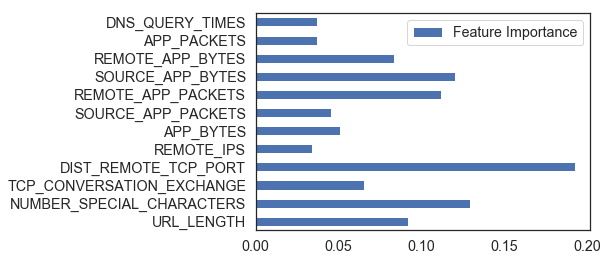

In [232]:
#--5. Report the most important feature(s) based on your Random Forest classifier (10 points)-- Create a plot

feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=train_data.columns[:12]).plot(kind='barh')

## Findings (#6)

In [302]:
#--6. Summarize your findings, including which classifier and paramters gave you the best results and include 
#-- an in-depth explanation of how you might improve your results.  You should also investigate what the different 
#-- fields mean, so you'll need to do some research about websites and internet protocols! (15 points)

**Which classifier and paramters gave you the best results:**
- Random Forest Best Parameters: cv=6, 'max_depth': 13, 'n_estimators': 26, Best score: 0.9719276356830941
- Naive Bayes Best Parameters: Using the DIST_REMOTE_TCP_PORT feature only and using priors=[.95, 0.05] gives Accuracy: 85.99%
- Overall, the Random Forest Classifier with cv=6, max_depth=13 and n_estimators=26 gave the best score of all the models I tried, which was 97.2%

**Dopped Columns**
- I dropped the following columns:'URL', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'CONTENT_LENGTH'

**The reason for dropping these columns is as follows:**
- I dropped the following columns because they increased dimensionality: URL, WHOIS_STATEPRO, WHOIS_COUNTRY, WHOIS_REGDATE, WHOIS_UPDATED_DATE, CHARSET, SERVER.
- I droped CONTENT_LENGTH because more than half of the values in the column were None. I initially left this column in and tried to fit my Random Forest model, but it gave me an accuracy score of 1.0. Once I took that column out, I got accuracy scores that were more in line with what I would have expected.  

**Naive Bayes**
After running Naive Bayes on the 13 columns of data, I got an accuracy score of around 30%. That seemed a bit low, so I found the most important feature for the Random Forest model and then ran the Naive Bayes model on that, or only DIST_REMOTE_TCP_PORT. After doing that, my Naive Bayes accuracy score went up to 85.99%.

**How I might improve my results**
- One way to improve my results could be including some of the categorical features. Possibly looking at the country of origin may be useful. I considered adding the state feature/column, but it seemed it would increase the dimensionality of the dataset too much. For Random Forest, another way to improve results could be trying more concrete cross validation folds, like checking cv=5 and cv=7. For this exercise, I checked an even number of folds only, including odd values could possibly improve my results. Also changing the hyperparameters a bit more could be helpful. To improve results for Naive Bayes, I could try to train the model on 3 of the most important features found from Random Forest instead of only the 1. 

**Different fields**
- The top 5 features that seemed to be the most important from Random Forest were: DIST_REMOTE_TCP_PORT, NUMBER_SPECIAL_CHARACTERS, SOURCE_APP_BYTES, REMOTE_APP_PACKET, and URL_LENGTH
- The one pertaining to special characters makes sense as you would expect to have more special characters, or characters that aren't numbers or from the alphabet in something that is spam, this can be seen in spam email as well. Source app bytes seems to be the number of apps transfered from the source; if coming from spam, it would make sense that it may differ. URL_LENGTH is pretty apparent. From the book, Intelligent Computing and Optimization, by Pandian Vassant, it seems that they also use the features, SOURCE_APP_BYTES, DIST_REMOTE_TCP_PORT, and a variation of REMOTE_APP_PACKET, to determine if a URL is from a benign or malicious website.    
- The bottom 5 features from Random Forest seemed to be: DNS_QUERY_TIMES, APP_PACKETS, SOURCE_APP_PACKETS, REMOTE_IPS, and, TCP_CONVERSATION_EXCHANGE
